### Overview

Association Rule Mining (ARM) is a technique used in data mining to discover interesting relationships, correlations, and patterns among items in large datasets. It identifies strong rules discovered in databases using measures like support, confidence, and lift. These rules are used to highlight frequent item sets and association patterns between variables in transactional datasets.

- Support: This refers to the proportion of transactions in the dataset that contain a particular item set. It measures how frequently an item or item set appears in the dataset.

- Confidence: Confidence refers to the likelihood that an item appears in a transaction given that another item is already present. It is the conditional probability of the occurrence of the consequent given the antecedent.

- Lift: Lift evaluates how much more likely the consequent is to occur when the antecedent occurs than it would be expected by random chance. It is calculated as the ratio of the observed support to the expected support if the items were independent.

The Apriori Algorithm is a popular algorithm used to perform ARM. It works by identifying the frequent item sets in the dataset and then generating association rules from them. The algorithm uses a bottom-up approach, where frequent item sets are extended one item at a time (a step known as candidate generation) and groups of candidates are tested against the data.

### Data Preperation

Association Rule Mining (ARM) requires data to be in transactional form, where each row represents a transaction and each column represents the presence or absence of an "item" in that transaction. In the context of air quality data, each row corresponds to a pollution measurement event, and each pollutant level (e.g., pm25_Low, no2_High) is treated as an item.

In order to convert the dataset into a suitable format for ARM:

The pollutant concentrations were binned into categories (Low, Medium, High) using quantiles.
This was followed by one-hot encoding, creating a binary matrix where each column indicates whether a particular pollutant level was present (True/1) or absent (False/0) in each transaction.
Below is a sample of the binary transactional data used in the ARM analysis:

In [4]:
import pandas as pd
import numpy as np

# Load the cleaned dataset
df = pd.read_csv('final_cleaned.csv')

# Ensure the correct pollutant columns are used (adjust as necessary)
pollutants = ['pm25', 'pm10', 'no2', 'so2', 'o3', 'co']

# Binning the pollutant values into categorical bins (Low, Medium, High)
for pollutant in pollutants:
    df[pollutant] = pd.qcut(df['value'][df['pollutant'] == pollutant], q=3, labels=['Low', 'Medium', 'High'])

# Pivot the dataset to have pollutant categories in columns
df_pivot = df.pivot_table(values='value', index=['location', 'city', 'country', 'timestamp', 'latitude', 'longitude'],
                          columns='pollutant', aggfunc='first')

# Reset index to make 'location', 'city', 'country', etc. columns again
df_pivot.reset_index(inplace=True)

# Binning pollutant values
for pollutant in pollutants:
    if pollutant in df_pivot.columns:
        df_pivot[pollutant] = pd.qcut(df_pivot[pollutant], q=3, labels=['Low', 'Medium', 'High'])

# Apply One-Hot Encoding to create the binary matrix
df_encoded = pd.get_dummies(df_pivot[pollutants])

# Display a sample of the encoded dataset
df_encoded.head()

,pm25_Low,pm25_Medium,pm25_High,pm10_Low,pm10_Medium,pm10_High,no2_Low,no2_Medium,no2_High,so2_Low,so2_Medium,so2_High,o3_Low,o3_Medium,o3_High,co_Low,co_Medium,co_High
0,False,False,False,False,True,False,False,True,False,False,False,True,False,False,True,False,True,False
1,False,False,False,False,False,True,False,False,True,False,False,True,False,True,False,False,False,True
2,False,False,False,True,False,False,False,True,False,False,False,True,False,False,True,False,True,False
3,False,False,False,True,False,False,False,True,False,False,False,True,False,False,True,False,True,False
4,False,False,False,False,False,True,False,False,True,False,False,True,False,True,False,False,False,True


In [51]:
# Save the prepared dataset to a CSV file (optional)
df_encoded.to_csv('prepared_pollutant_data_for_ARM.csv', index=False)

### Code: ARM with Apriori Algorithm

In [36]:
from mlxtend.frequent_patterns import apriori, association_rules

# Apply the Apriori algorithm to find frequent itemsets
# Set a lower minimum support threshold to capture more itemsets
frequent_itemsets = apriori(df_encoded, min_support=0.02, use_colnames=True)

# Display the frequent itemsets
print(frequent_itemsets)

# Apply the association rule mining with a lower confidence threshold
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.35)

     support                    itemsets
0   0.145143                  (pm25_Low)
1   0.144529               (pm25_Medium)
2   0.144096                 (pm25_High)
3   0.122950                  (pm10_Low)
4   0.122950               (pm10_Medium)
5   0.122950                 (pm10_High)
6   0.143313                   (no2_Low)
7   0.144062                (no2_Medium)
8   0.141430                  (no2_High)
9   0.075513                   (so2_Low)
10  0.075236                (so2_Medium)
11  0.074908                  (so2_High)
12  0.177504                    (o3_Low)
13  0.169685                 (o3_Medium)
14  0.173595                   (o3_High)
15  0.053333                    (co_Low)
16  0.053209                 (co_Medium)
17  0.052501                   (co_High)
18  0.046833        (pm25_Low, pm10_Low)
19  0.028305         (no2_Low, pm25_Low)
20  0.036426          (pm25_Low, o3_Low)
21  0.030557     (pm10_Low, pm25_Medium)
22  0.034634  (pm10_Medium, pm25_Medium)
23  0.023046    

In [37]:
top_support_rules = rules.sort_values(by="support", ascending=False).head(15)
top_support_rules[['antecedents', 'consequents', 'support']]

,antecedents,consequents,support
5,(no2_Medium),(o3_High),0.059764
1,(pm10_High),(pm25_High),0.056471
2,(pm25_High),(pm10_High),0.056471
0,(pm10_Low),(pm25_Low),0.046833
3,(so2_Low),(no2_Low),0.042159
4,(co_Low),(no2_Low),0.032584
9,(so2_Medium),(o3_High),0.029653
7,(so2_Low),(o3_Low),0.029192
11,(co_Low),(o3_Low),0.025091
6,(co_High),(no2_High),0.023399


In [38]:
top_confidence_rules = rules.sort_values(by="confidence", ascending=False).head(15)
top_confidence_rules[['antecedents', 'consequents', 'confidence']]

,antecedents,consequents,confidence
15,"(o3_Low, so2_Low)",(no2_Low),0.707607
4,(co_Low),(no2_Low),0.610958
3,(so2_Low),(no2_Low),0.558306
14,"(no2_Low, so2_Low)",(o3_Low),0.489965
13,"(no2_Low, o3_Low)",(so2_Low),0.487495
11,(co_Low),(o3_Low),0.470458
1,(pm10_High),(pm25_High),0.459299
6,(co_High),(no2_High),0.445691
10,(co_High),(so2_High),0.430057
5,(no2_Medium),(o3_High),0.414853


In [39]:
top_lift_rules = rules.sort_values(by="lift", ascending=False).head(15)
top_lift_rules[['antecedents', 'consequents', 'lift']]

,antecedents,consequents,lift
13,"(no2_Low, o3_Low)",(so2_Low),6.455764
10,(co_High),(so2_High),5.741167
8,(co_Low),(so2_Low),5.447622
15,"(o3_Low, so2_Low)",(no2_Low),4.937505
4,(co_Low),(no2_Low),4.263109
3,(so2_Low),(no2_Low),3.895720
1,(pm10_High),(pm25_High),3.187463
2,(pm25_High),(pm10_High),3.187463
6,(co_High),(no2_High),3.151314
14,"(no2_Low, so2_Low)",(o3_Low),2.760308


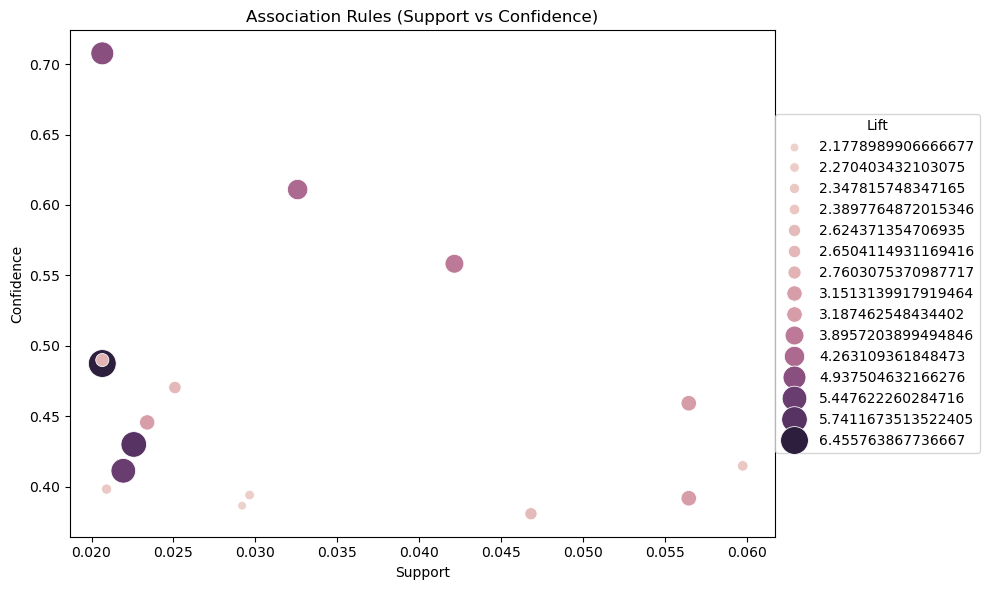

In [50]:
import seaborn as sns

plt.figure(figsize=(10,6))

# Use sns.scatterplot with lift as the hue and size, and place the legend outside
sns.scatterplot(x='support', y='confidence', size='lift', hue='lift', data=rules, sizes=(40, 400), legend="full")

# Add title and axis labels
plt.title('Association Rules (Support vs Confidence)')
plt.xlabel('Support')
plt.ylabel('Confidence')

# Position the legend outside the plot area
plt.legend(title='Lift', loc='center left', bbox_to_anchor=(1, 0.5), borderaxespad=0)

plt.tight_layout()
plt.show()

Visualization of Association Rules:

To visualize the associations, a network diagram was generated to depict the relationships between pollutant levels. Each node represents a pollutant (at varying levels like low, medium, high), and the edges represent association rules. The thickness of the edges correlates to the support, while the color intensity correlates to the lift of the rule.

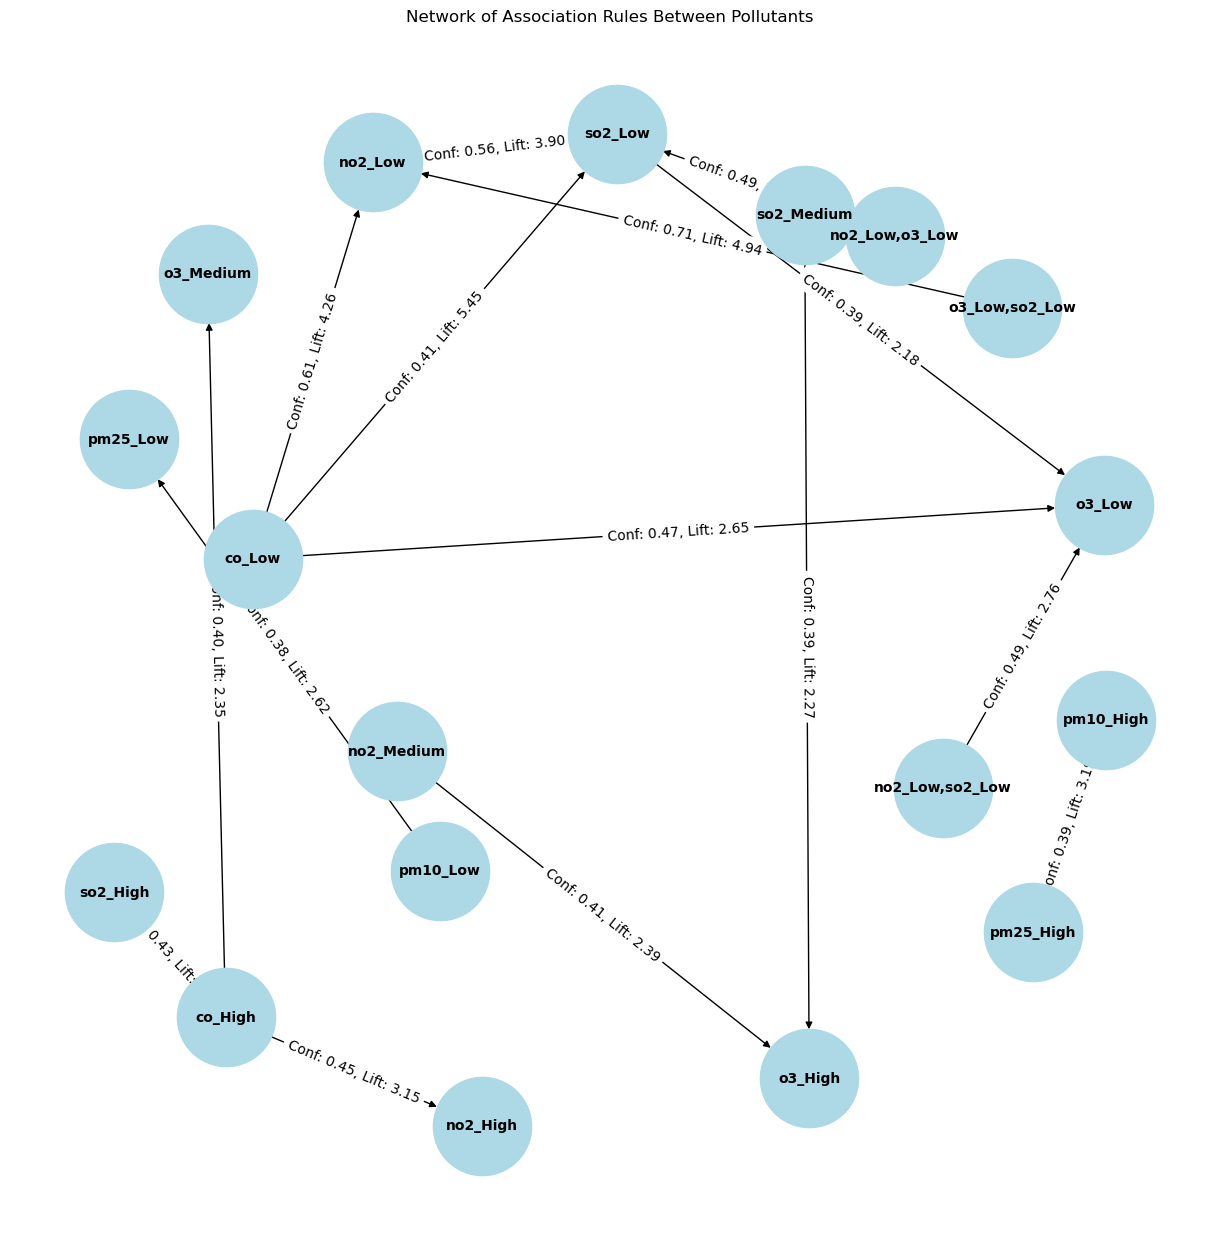

In [53]:
# Visualization: Network of Association Rules
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.DiGraph()

# Add nodes and edges for antecedents and consequents
for idx, row in rules.iterrows():
    G.add_edge(','.join(list(row['antecedents'])), ','.join(list(row['consequents'])),
               weight=row['support'], label=f"Conf: {row['confidence']:.2f}, Lift: {row['lift']:.2f}")

# Plot the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=5000, font_size=10, font_weight='bold')

# Draw edges
edges = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edges)

plt.title('Network of Association Rules Between Pollutants')
plt.show()